In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.models import Sequential, Model
from keras.callbacks import TensorBoard, ModelCheckpoint
from sgdr import SGDRScheduler

import numpy as np
import matplotlib.pyplot as plt

import keras.backend as K

/home/kenny/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_dir = "./train"
validation_dir = "./test"

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size = (28,28),
    batch_size=20,
    class_mode= 'categorical',
    color_mode = 'grayscale')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = (28,28),
    batch_size=20,
    class_mode = 'categorical',
    color_mode = 'grayscale')

for data_batch, labels_batch in train_generator:
    print('Data batch shape: ', data_batch.shape)
    print('Labels batch shape: ', labels_batch.shape)
    break

Found 3645000 images belonging to 81 classes.
Found 202500 images belonging to 81 classes.
Data batch shape:  (20, 28, 28, 1)
Labels batch shape:  (20, 81)


In [80]:
# callbacks
epochs = 10000
batch_size = 64
epoch_size = 15000

schedule = SGDRScheduler(min_lr=1e-5,
                         max_lr=1e-3,
                         steps_per_epoch=np.ceil(epoch_size/batch_size),
                         lr_decay=0.9,
                         cycle_length=10,
                         mult_factor=1.5)

tensorboard = TensorBoard(log_dir='./graph', histogram_freq=0,
                          write_graph=True, write_images=False)
filepath="models/checkpoints/best_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [72]:
# construct model

print('\nClearing old graphs...')
graph = os.listdir('graph')
for file in graph:
  os.remove('graph/{}'.format(file))

K.clear_session()
model = Sequential()
model.add(Conv2D(32, (2,2), activation = 'relu', input_shape = (28, 28, 1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (2,2), activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (2,2), activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(89, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])



Clearing old graphs...


In [73]:
model_json = model.to_json()
with open("models/model.json", "w") as json_file:
    json_file.write(model_json)
    
hist = model.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps=50,
    callbacks = [schedule, tensorboard, checkpoint])

3766

Epoch 1/10000
100/100 [==============================] - 1s 14ms/step - loss: 4.4863 - acc: 0.0185 - val_loss: 4.4560 - val_acc: 0.0270

Epoch 00001: val_acc did not improve from 0.61800
Epoch 2/10000
100/100 [==============================] - 3s 29ms/step - loss: 4.3150 - acc: 0.0415 - val_loss: 4.1001 - val_acc: 0.0580

Epoch 00002: val_acc did not improve from 0.61800
Epoch 3/10000
100/100 [==============================] - 3s 29ms/step - loss: 3.8806 - acc: 0.0955 - val_loss: 3.6984 - val_acc: 0.1220

Epoch 00003: val_acc did not improve from 0.61800
Epoch 4/10000
100/100 [==============================] - 1s 10ms/step - loss: 3.6510 - acc: 0.1410 - val_loss: 3.4565 - val_acc: 0.1950

Epoch 00004: val_acc did not improve from 0.61800
Epoch 5/10000
100/100 [==============================] - 1s 10ms/step - loss: 3.4711 - acc: 0.1645 - val_loss: 3.2867 - val_acc: 0.2160

Epoch 00005: val_acc did not improve from 0.61800
Epoch 6/10000
100/100 [==============================] - 1s 10ms/


Epoch 00044: val_acc did not improve from 0.61800
Epoch 45/10000
100/100 [==============================] - 1s 11ms/step - loss: 2.0760 - acc: 0.4805 - val_loss: 1.7825 - val_acc: 0.5510

Epoch 00045: val_acc did not improve from 0.61800
Epoch 46/10000
100/100 [==============================] - 1s 11ms/step - loss: 2.1003 - acc: 0.4795 - val_loss: 1.7726 - val_acc: 0.5550

Epoch 00046: val_acc did not improve from 0.61800
Epoch 47/10000
100/100 [==============================] - 2s 19ms/step - loss: 2.0971 - acc: 0.4675 - val_loss: 1.7436 - val_acc: 0.5640

Epoch 00047: val_acc did not improve from 0.61800
Epoch 48/10000
100/100 [==============================] - 3s 31ms/step - loss: 2.0107 - acc: 0.4935 - val_loss: 1.7224 - val_acc: 0.5610

Epoch 00048: val_acc did not improve from 0.61800
Epoch 49/10000
100/100 [==============================] - 2s 20ms/step - loss: 2.0351 - acc: 0.4740 - val_loss: 1.7263 - val_acc: 0.5480

Epoch 00049: val_acc did not improve from 0.61800
Epoch 50/

KeyboardInterrupt: 

## Testing model

In [1]:
from keras.models import model_from_json

json_file = open('models/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('models/checkpoints/best_weights.hdf5')

/home/kenny/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import os
import pickle
with open("class_ids.txt", 'rb') as fp:
    class_idx = pickle.load(fp)
categories = os.listdir('full')
categories = [s.replace('.npy', '') for s in categories]

/home/kenny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


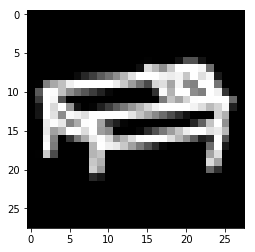

In [3]:
import imageio
from scipy.misc import imresize
import matplotlib.pyplot as plt
%matplotlib inline
test_pred = imageio.imread('test_predictions/bed9.png', pilmode = 'L')
# test_pred = np.invert(test_pred)
test_pred = imresize(test_pred, (28,28) )

# test_pred = imageio.imread('test_predictions/lightning0.png')

plt.imshow(test_pred/255, cmap = 'gray')

In [ ]:
test_pred_reshaped = test_pred.reshape(1, 28, 28, 1)/255
pred = loaded_model.predict(test_pred_reshaped)

In [1]:
import pandas as pd
# class_idx = train_generator.class_indices

class_idx_df = pd.DataFrame({'classes':list(class_idx.keys())}).reset_index()
sorted_probs = pd.DataFrame({'probabilities':pred.ravel()}).sort_values(by = 'probabilities', ascending=False).\
                            reset_index()

merged = pd.merge(class_idx_df, sorted_probs).sort_values('probabilities', ascending=False).drop('index', axis=1)
merged

NameError: name 'class_idx' is not defined

In [8]:
import pickle
with open("class_ids.txt", "wb") as fp:
    pickle.dump(class_idx, fp)

In [1]:
# removing unused categories


import os
not_used = os.listdir('not_used_categories/')
not_used = [s.replace('.npy', '') for s in not_used]
not_used = [s.replace(' ', '_') for s in not_used]


for item in not_used:
    if os.path.exists('train/' + item):
        os.rmdir('train/' + item)
    if os.path.exists('test/'+ item):
        os.rmdir('test/' + item)
    if os.path.exists('validation/' + item):    
        os.rmdir('validation/' + item)